In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate

from src.model import tscv, ClippedOutputRegressor
from src.data import get_feature_cols, df_to_X_y, drop_non_features

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


Again let's load the baseline model:

In [2]:
baseline_reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model'))

Now some functions that will help us.

In [3]:
def scores_df(scores):
    return pd.DataFrame({
        'test_score_mean': [np.mean(s['test_score']) for s in scores],
        'test_score_std': [np.std(s['test_score']) for s in scores],
        'test_score_last_fold': [s['test_score'][-1] for s in scores]
    })

def plt_scores(scores_df):
    df = scores_df.copy()
    df['idx'] = df.index
    df = df.melt(value_vars=['test_score_mean', 'test_score_last_fold'], id_vars=['idx'],value_name='neg_RMSE')
    sns.lineplot(data=df, x='idx', y='neg_RMSE', hue='variable')
    
def validate(df, reg_val=baseline_reg, verbose=2, cv_splits=None):
    if not cv_splits:
        cv_splits = tscv.split(df['date_block_num'])
    X_train, y_train = df_to_X_y(df)
    scores = cross_validate(reg_val, X=X_train, y=y_train, 
                            cv=cv_splits, 
                            scoring='neg_root_mean_squared_error', verbose=verbose)
    print("RMSE: %.5f (+- %.5f)" % (np.mean(scores['test_score']), np.std(scores['test_score'])))
    return scores

# Time window selection

Let's first check if the time window we use to train is optimal. We'll do this by selecting the one that yields the best CV score (which means we will basically treat it as an extra hyperparameter) when using the most complete feature set so far and the baseline model.

In [4]:
train_set_008 = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-features-008.parquet'))

In [5]:
X_train, y_train = df_to_X_y(train_set_008)
windows_scores = [cross_validate(baseline_reg, X=X_train, y=y_train, 
                                 cv=tscv.split(train_set_008['date_block_num'], 
                                               window=w), 
                                 scoring='neg_root_mean_squared_error', 
                                 verbose=0)
                 for w in tqdm(range(1, 32))]

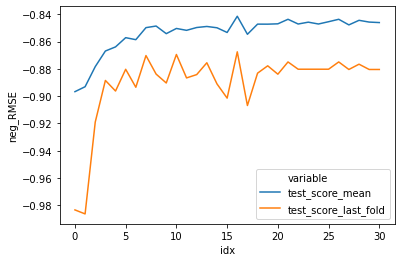

In [6]:
plt_scores(scores_df(windows_scores))

Ok, we can see using all the data doesn't hurt, but we can drop most of it to make our iterations a lot faster.

<AxesSubplot:>

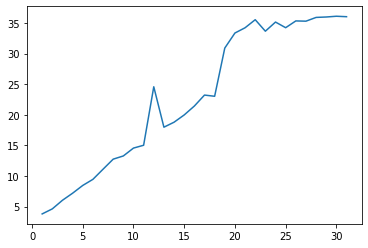

In [7]:
sns.lineplot(x=range(1, 32), y=[np.max(s['fit_time']) for s in windows_scores])